1. Initial Exploration & Column Categorization
Since data types might be incorrect due to missing values, start by identifying column types based on actual content, rather than relying on df.dtypes.

Key Steps:
Get an overview of missing values and unique counts.
Identify numeric columns (int64, float64) and check if floats can be converted to integers.
Identify categorical/text columns and check for inconsistencies.
Group columns based on relevance, such as:
Identifiers (e.g., IDs, names)
Date/time variables
Financial/quantitative variables
Categorical variables
Text-based variables (e.g., descriptions)
Code Example:
python
Copy
Edit
import pandas as pd

# Identify missing values and unique values
missing_counts = df.isnull().sum()
unique_counts = df.nunique()

# Identify potential int columns (floats with no decimals)
float_cols = df.select_dtypes(include=['float64']).columns
int_candidates = [col for col in float_cols if df[col].dropna().mod(1).eq(0).all()]

# Convert them
df[int_candidates] = df[int_candidates].astype("Int64")  # Pandas nullable integer type

# Categorizing columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
date_cols = [col for col in df.columns if 'date' in col.lower()]  # Adjust based on known data
2. Handling Missing Data
Instead of dropping missing values blindly, handle them based on the column type:

Numeric Columns: Impute with mean, median, or zero depending on context.
Categorical Columns: Fill with mode, "Unknown", or "Missing" if it makes sense.
Dates: Forward/backward fill where logical.
Code Example:
python
Copy
Edit
# Fill missing values
for col in numeric_cols:
    df[col].fillna(df[col].median(), inplace=True)  # Use median to avoid skewing

for col in categorical_cols:
    df[col].fillna("Unknown", inplace=True)  # Assign "Unknown" to missing text data
3. Standardizing Text Data
Convert categorical/text values to consistent casing.
Strip leading/trailing spaces.
Handle potential inconsistencies like "NY" vs. "New York".
Code Example:
python
Copy
Edit
for col in categorical_cols:
    df[col] = df[col].astype(str).str.strip().str.lower()  # Standardize text
4. Detecting Outliers & Incorrect Entries
For numeric data, use IQR (Interquartile Range) to find outliers and decide how to handle them.
For categorical data, check for inconsistent spellings or values that don’t belong.

Code Example:
python
Copy
Edit
from scipy.stats import iqr

# Identify outliers using IQR
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR)))
    print(f"{col}: {outliers.sum()} potential outliers")
5. Correcting Data Types
Once missing values are handled and text is standardized, convert data types properly:

Ensure date columns are datetime64.
Ensure categorical variables use category dtype for efficiency.
Ensure floats that should be integers are properly converted.
Code Example:
python
Copy
Edit
# Convert date columns
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors="coerce")

# Convert categorical columns to category dtype
for col in categorical_cols:
    df[col] = df[col].astype("category")
6. Automating the Cleaning Process
To make this repeatable, wrap steps in functions and call them in sequence:

python
Copy
Edit
def clean_numeric_data(df):
    float_cols = df.select_dtypes(include=['float64']).columns
    int_candidates = [col for col in float_cols if df[col].dropna().mod(1).eq(0).all()]
    df[int_candidates] = df[int_candidates].astype("Int64")  # Convert cleanable floats to int
    
    for col in df.select_dtypes(include=['int64', 'float64']):
        df[col].fillna(df[col].median(), inplace=True)
    
    return df

def clean_categorical_data(df):
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype(str).str.strip().str.lower().fillna("unknown")
    
    return df

def clean_date_data(df):
    date_cols = [col for col in df.columns if 'date' in col.lower()]
    for col in date_cols:
        df[col] = pd.to_datetime(df[col], errors="coerce")
    
    return df

def clean_dataset(df):
    df = clean_numeric_data(df)
    df = clean_categorical_data(df)
    df = clean_date_data(df)
    return df

# Apply the cleaning process
df_cleaned = clean_dataset(df)

Step 1: Initial Exploration & Data Type Validation
Before cleaning, we need to identify issues such as:

Columns with mixed data types (e.g., numeric columns containing strings).
Columns that should be categorical but have too many unique values.
Columns with missing values and their proportions.
Logic & Approach:
If a column is supposed to be numeric but has more than 5% of unique non-numeric values, flag it as "potentially corrupted."
If a column has a small number of unique values compared to total rows, it might be categorical instead of text.
Code Implementation:
python
Copy
Edit
import pandas as pd
import numpy as np

def detect_mixed_data_types(df):
    """
    Identify columns with mixed data types and flag them for correction.
    """
    potential_issues = {}

    for col in df.columns:
        unique_vals = df[col].dropna().unique()
        num_numeric = sum(pd.to_numeric(unique_vals, errors='coerce').notna())
        num_strings = len(unique_vals) - num_numeric
        
        # If more than 5% of unique values are non-numeric in a numeric-looking column, flag it
        if num_strings > 0 and num_strings / len(unique_vals) > 0.05:
            potential_issues[col] = {
                'total_unique': len(unique_vals),
                'num_numeric': num_numeric,
                'num_strings': num_strings
            }
    
    return potential_issues

# Run the detection function
mixed_type_columns = detect_mixed_data_types(df)
print("Potential mixed-type columns:", mixed_type_columns)
📌 Outcome: This function flags columns with numeric contamination and prepares them for conversion in Step 7.

Step 2: Missing Value Handling
Group-Based Imputation

If a column has missing values, fill them using the median/mean within each group (e.g., Country → Inflation Rate).
Forward & Backward Fill for Time Series

If the dataset contains time-based data, fill missing values based on trends.
Code Implementation:
python
Copy
Edit
def impute_by_group(df, target_col, group_col, method='median'):
    """
    Fill missing values in 'target_col' based on group-wise values in 'group_col'.
    """
    if method == 'median':
        df[target_col] = df.groupby(group_col)[target_col].transform(lambda x: x.fillna(x.median()))
    elif method == 'mean':
        df[target_col] = df.groupby(group_col)[target_col].transform(lambda x: x.fillna(x.mean()))
    elif method == 'mode':
        df[target_col] = df.groupby(group_col)[target_col].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan))
    
    return df

# Example usage: Fill Inflation_Rate based on Country
df = impute_by_group(df, target_col='Inflation_Rate', group_col='Country', method='median')

# Forward & Backward Fill for Time Series
df = df.sort_values(by=['Date']).groupby('Country').apply(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
Step 3: Standardizing Text Data
Convert text to lowercase, strip spaces, and correct spelling inconsistencies using fuzzy matching.
Detect near-duplicate categorical values and map them to a standard format.
Code Implementation:
python
Copy
Edit
from fuzzywuzzy import process

def standardize_text(df, col, reference_values=None, threshold=90):
    """
    Standardize categorical values by matching them to a reference list using fuzzy matching.
    """
    if reference_values is None:
        reference_values = df[col].dropna().unique()  # Use unique existing values if no reference

    df[col] = df[col].apply(lambda x: process.extractOne(x, reference_values)[0] if pd.notna(x) else x)
    return df

# Example usage: Standardize 'Country' names
df = standardize_text(df, 'Country', reference_values=['United States', 'Canada', 'United Kingdom'])
Step 4: Detecting & Handling Duplicates
Instead of removing duplicates outright, we use fuzzy matching for near-duplicates.

Code Implementation:
python
Copy
Edit
from fuzzywuzzy import fuzz

def detect_near_duplicates(df, col, threshold=90):
    """
    Identify near-duplicate values in a column using fuzzy string matching.
    """
    unique_vals = df[col].dropna().unique()
    duplicates = {}

    for val in unique_vals:
        match = process.extractOne(val, unique_vals)
        if match and match[1] >= threshold and val != match[0]:
            duplicates[val] = match[0]  # Map incorrect to correct

    return duplicates

# Example usage: Find duplicate company names
duplicate_mappings = detect_near_duplicates(df, 'Company_Name')

# Replace incorrect names with correct ones
df['Company_Name'] = df['Company_Name'].replace(duplicate_mappings)
Step 5: Outlier Detection & Winsorization
Instead of removing extreme values, cap them at the 5th and 95th percentile.

Code Implementation:
python
Copy
Edit
from scipy.stats.mstats import winsorize

def winsorize_column(df, col, lower=0.05, upper=0.05):
    """
    Winsorize column by capping extreme values at given percentiles.
    """
    df[col] = winsorize(df[col], limits=[lower, upper])
    return df

# Example usage: Winsorize Sales data
df = winsorize_column(df, 'Sales')
Step 6: Regression Imputation for Missing Values
Use a regression model to predict missing values based on correlated features.

Code Implementation:
python
Copy
Edit
from sklearn.linear_model import LinearRegression

def regression_impute(df, target_col, feature_cols):
    """
    Predict and fill missing values in 'target_col' using a regression model based on 'feature_cols'.
    """
    train_data = df.dropna(subset=[target_col])  # Remove rows where target_col is NaN
    test_data = df[df[target_col].isna()]  # Rows where target_col is missing

    model = LinearRegression()
    model.fit(train_data[feature_cols], train_data[target_col])

    df.loc[df[target_col].isna(), target_col] = model.predict(test_data[feature_cols])
    return df

# Example usage: Predict missing Salaries based on Experience & Education
df = regression_impute(df, target_col='Salary', feature_cols=['Experience', 'Education_Level'])
Step 7: Correcting Mixed Data Types
Detect numeric columns with string contamination (Step 1).
Convert them to numeric while handling errors.
Fill remaining NaNs with median values.
Code Implementation:
python
Copy
Edit
def fix_mixed_data_types(df, mixed_columns):
    """
    Convert flagged mixed-type columns to numeric, handling errors and filling NaNs.
    """
    for col in mixed_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric
        df[col].fillna(df[col].median(), inplace=True)  # Fill missing values
    
    return df

# Apply the fix
df = fix_mixed_data_types(df, mixed_type_columns.keys())
Final Thoughts
This cleaning process is: ✔ Modular – Each step is a function that can be reused.
✔ Scalable – Works for large datasets with 100k+ rows.
✔ Transparent – Provides explanations for each transformation.

# Implentation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets
from sklearn import cluster
import sklearn
import seaborn as sns
from sklearn import decomposition
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
from scipy.stats import boxcox
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [15]:
# allow us to see all columns
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv("../Datasets_P1/df_Cost.csv")
df.sample(5)

C:\Users\perreaultl1\AppData\Local\Temp\ipykernel_7824\3932104159.py:1: DtypeWarning: Columns (8,89) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../Datasets_P1/df_Cost.csv")


,rpt_rec_num,Provider_CCN,Facility_Name,Street_Address,City,State_Code,Zip_Code,County,Medicare_CBSA_Number,Rural_versus_Urban,...,Total_Current_Assets,Total_Other_Income,SNF_Bed_Days_Available,Leasehold_improvements,Mortgage_payable,Notes_and_Loans_Payable_(short_term),Land,Inventory,Prepaid_expenses,Year
100899,1336415,305063,PRESIDENTIAL OAKS,200 PLEASANT STREET,CONCORD,NH,03301,MERRIMACK,99930.0,R,...,2990621.0,3183992.0,31025.0,NaN,NaN,140221.0,7500.0,37742.0,25033.0,2021
47530,1226185,45451,CREEKSIDE HEALTH & REHAB,620 NORTH PANTHER AVENUE,YELLVILLE,AR,72687,MARION,99904.0,R,...,1335814.0,449.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
48401,1236291,225608,137 NICHOLS STREET INC.,137 NICHOLS STREET,NORWOOD,MA,2062,NORFOLK,14454.0,U,...,219489.0,35071.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
3063,1137424,165255,CARLISLE CARE CENTER,680 COLE STREET,CARLISLE,IA,50047,WARREN,19780.0,U,...,-2245384.0,64908.0,NaN,NaN,NaN,NaN,119000.0,NaN,NaN,2015
43060,1238506,395877,HIGHLAND VIEW HEALTHCARE AND REHAB,90 MAIN STREET,BROCKWAY,PA,15824,JEFFERSON,99939.0,R,...,731138.0,506726.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017


Text(0.5, 1.0, 'Missing Values Heatmap')

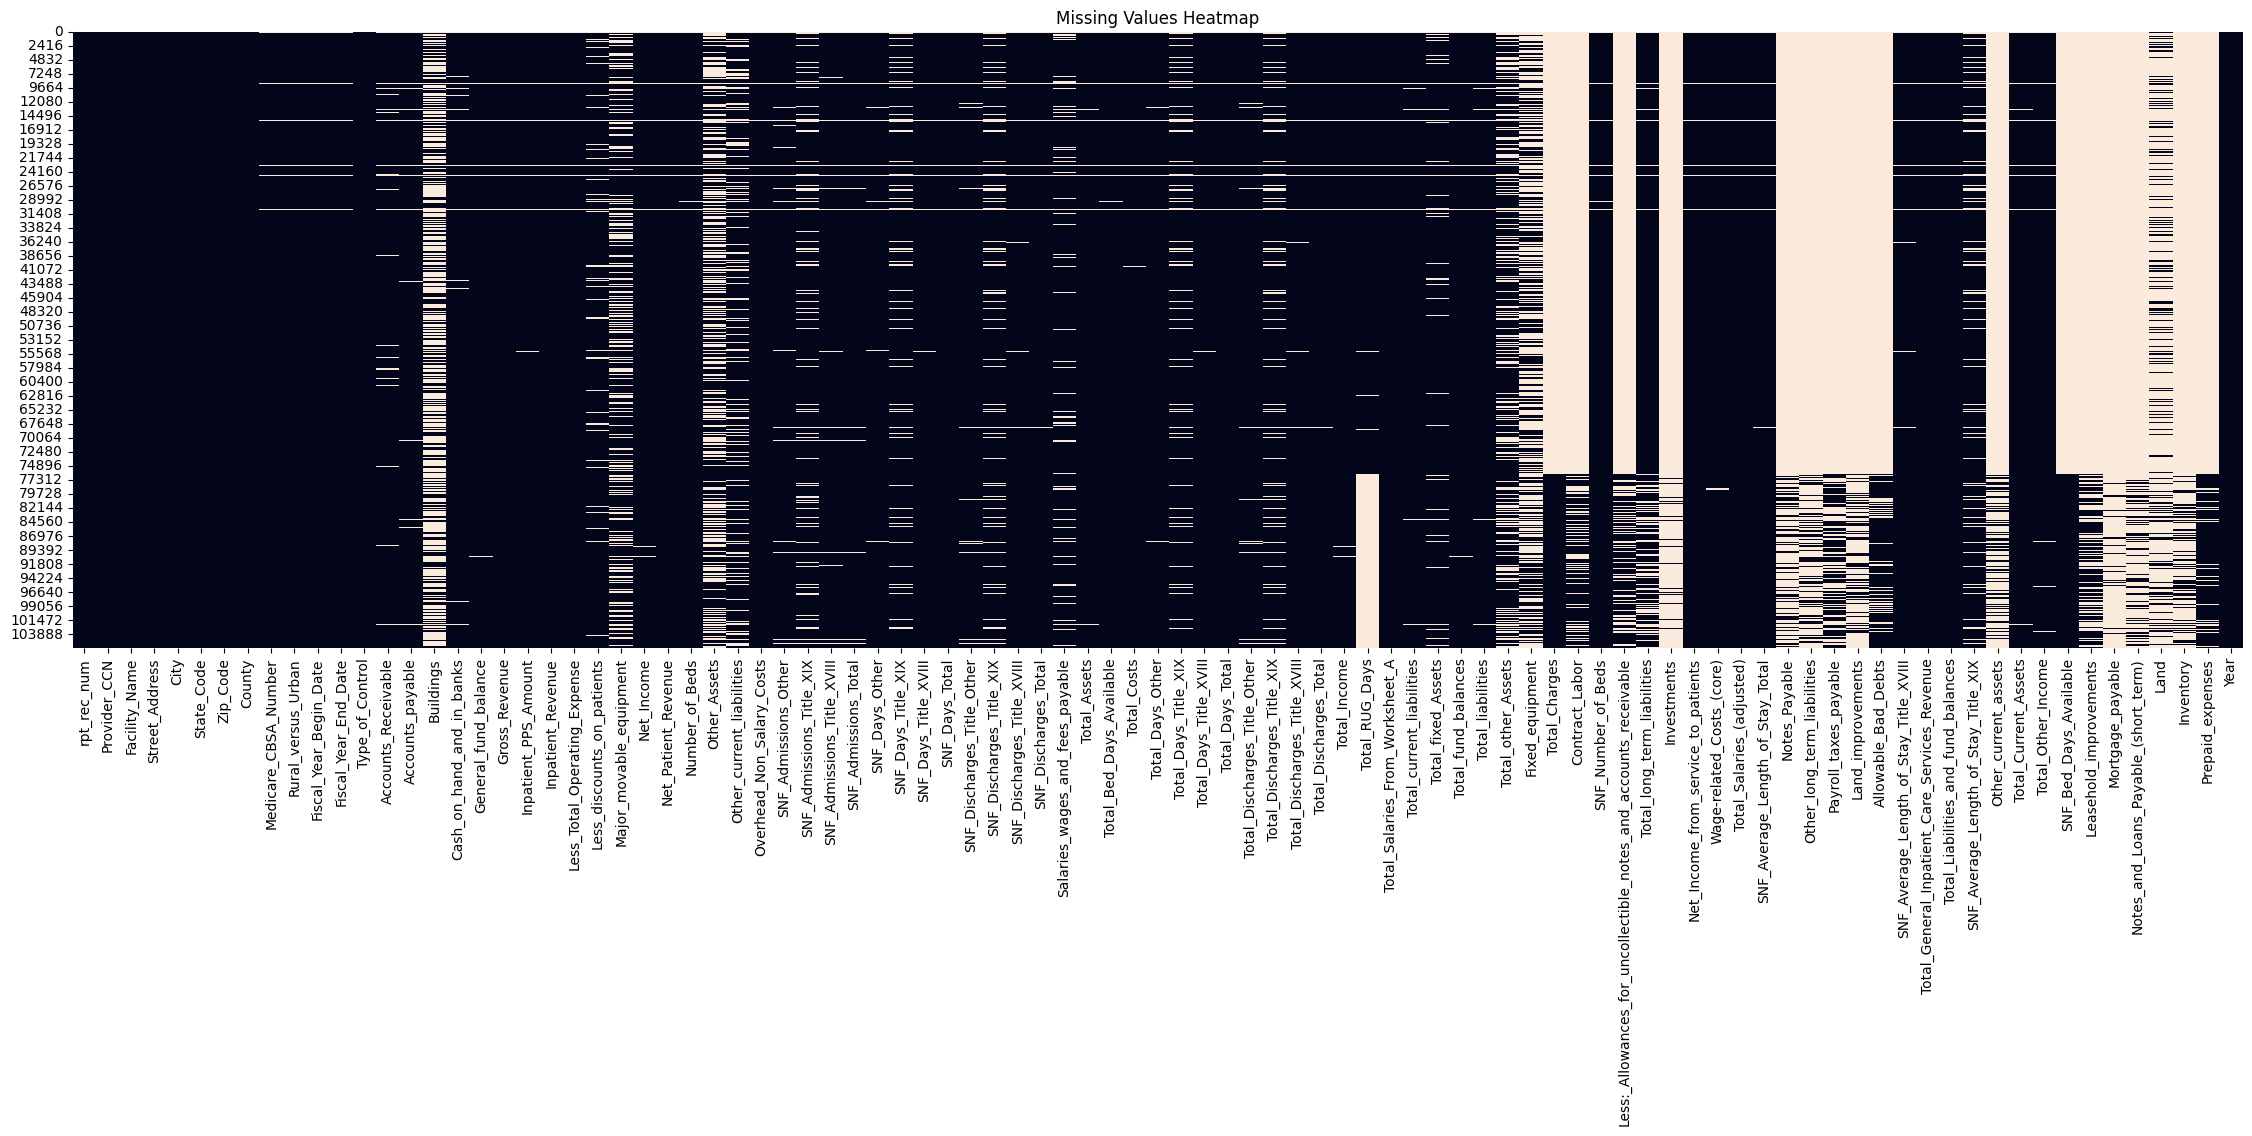

In [8]:
plt.figure(figsize=(28, 8))
sns.heatmap(df.isnull(), cbar=False)   # and do df21
plt.title("Missing Values Heatmap")

# Deal with Target

In [11]:
# Count of missing Net_Income values
num_missing_net_income = df['Net_Income'].isna().sum()

# Count of observations missing 50% or more of their data
num_cols = df.shape[1]  # Total number of columns
num_missing_50 = (df.isna().sum(axis=1) >= num_cols * 0.5).sum()

# Count of observations that satisfy both conditions
num_both_conditions = ((df['Net_Income'].isna()) & (df.isna().sum(axis=1) >= num_cols * 0.5)).sum()

# Print results
print(f"Count of NA Net_Income: {num_missing_net_income}")
print(f"Count of rows missing 50%+ of their data: {num_missing_50}")
print(f"Count of rows with both NA Net_Income and 50%+ missing data: {num_both_conditions}")


Count of NA Net_Income: 2360
Count of rows missing 50%+ of their data: 2118
Count of rows with both NA Net_Income and 50%+ missing data: 2074


In [13]:
# Executive Decision is to take out of the rows with more than 50% missing AND NA Net Income.
# The rest of the missing Net_Income Na I will see if I can calculate. 
# Get total column count
num_cols = df.shape[1]

# Create a mask for both conditions
mask_to_drop = (df['Net_Income'].isna()) & (df.isna().sum(axis=1) > num_cols * 0.5)

# Drop those rows
df = df[~mask_to_drop].copy()  # Keep the rest of the data

# Print confirmation
num_dropped = mask_to_drop.sum()
print(f"Dropped {num_dropped} rows that had NA Net_Income AND more than 50% missing data.")

# Remaining Net_Income missing values (to be calculated later)
remaining_na_net_income = df['Net_Income'].isna().sum()
print(f"Remaining missing Net_Income values to handle: {remaining_na_net_income}")


Dropped 2074 rows that had NA Net_Income AND more than 50% missing data.
Remaining missing Net_Income values to handle: 286


In [27]:
selected_columns = ['Gross_Revenue', 'Net_Income', 'Total_Costs', 'Total_Income', "Less_Total_Operating_Expense", "Overhead_Non_Salary_Costs", "Net_Income_from_service_to_patients", "Net_Patient_Revenue"]
df_selected = df[selected_columns].copy()  # Create a separate dataframe

# Display the first few rows to check
df_selected.tail(3)
# I just found out that total income and net income are the same thing and have the same values. 

,Gross_Revenue,Net_Income,Total_Costs,Total_Income,Less_Total_Operating_Expense,Overhead_Non_Salary_Costs,Net_Income_from_service_to_patients,Net_Patient_Revenue
106266,9009085.0,1916693.0,1111339.0,1916693.0,6086547.0,2799973.0,1391159.0,7477706.0
106267,12738362.0,1188367.0,1250246.0,1188367.0,15288127.0,9249788.0,-2549765.0,12738362.0
106268,9991720.0,739852.0,1493029.0,739852.0,9536736.0,4401409.0,454984.0,9991720.0


In [28]:
# Calculate 'netincometest' for the entire dataset
df_selected['netincometest'] = df_selected['Gross_Revenue'] - (df_selected['Total_Costs'])

# Display the first few rows to check
df_selected[['Gross_Revenue', 'Total_Costs', 'Less_Total_Operating_Expense', 'Net_Income' , 'netincometest']].head()


,Gross_Revenue,Total_Costs,Less_Total_Operating_Expense,Net_Income,netincometest
0,1800296.0,211585.0,1209322.0,311430.0,1588711.0
1,2843541.0,207903.0,3005301.0,-588469.0,2635638.0
2,613243.0,22920.0,639168.0,-47859.0,590323.0
3,1935277.0,158386.0,1444469.0,-63638.0,1776891.0
4,818175.0,56556.0,775242.0,-1613.0,761619.0


I cannot calaculate Net_Income. I will drop the 286 rows. I can use it later in the model I build perhaps. I will drop at the very end then so I fill in the NA in the other rows.

# Step 1: Initial Exploration & Data Type Validation


In [29]:
import pandas as pd
import numpy as np

def detect_mixed_data_types(df):
    """
    Identify columns with mixed data types and separate those with mostly numeric values but minor string contamination.
    """
    potential_issues = {}
    mostly_numeric_columns = {}

    for col in df.columns:
        unique_vals = pd.Series(df[col].dropna().unique())  # Convert to pandas Series
        num_numeric = sum(pd.to_numeric(unique_vals, errors='coerce').notna())
        num_strings = len(unique_vals) - num_numeric
        total_unique = len(unique_vals)

        if total_unique > 0:  # Avoid division by zero
            string_ratio = num_strings / total_unique
            numeric_ratio = num_numeric / total_unique

            # Flag columns with significant mixed data issues (>5% strings)
            if string_ratio >= 0.05:
                potential_issues[col] = {
                    'total_unique': total_unique,
                    'num_numeric': num_numeric,
                    'num_strings': num_strings
                }

            # Identify columns that are **mostly numeric** but contain **at least one string** (0% < string_ratio < 5%)
            if 0 < string_ratio < 0.05:
                mostly_numeric_columns[col] = {
                    'total_unique': total_unique,
                    'num_numeric': num_numeric,
                    'num_strings': num_strings
                }

    return potential_issues, mostly_numeric_columns

# Run the function
mixed_type_columns, mostly_numeric_columns = detect_mixed_data_types(df)

print("Potential mixed-type columns with significant string contamination:", mixed_type_columns)
print("\nColumns that are mostly numeric but contain <5% strings:", mostly_numeric_columns)


Potential mixed-type columns with significant string contamination: {'Facility_Name': {'total_unique': 22293, 'num_numeric': 1, 'num_strings': 22292}, 'Street_Address': {'total_unique': 19049, 'num_numeric': 15, 'num_strings': 19034}, 'City': {'total_unique': 5569, 'num_numeric': 2, 'num_strings': 5567}, 'State_Code': {'total_unique': 52, 'num_numeric': 0, 'num_strings': 52}, 'Zip_Code': {'total_unique': 11564, 'num_numeric': 9463, 'num_strings': 2101}, 'County': {'total_unique': 2154, 'num_numeric': 9, 'num_strings': 2145}, 'Rural_versus_Urban': {'total_unique': 2, 'num_numeric': 0, 'num_strings': 2}, 'Fiscal_Year_Begin_Date': {'total_unique': 1003, 'num_numeric': 0, 'num_strings': 1003}, 'Fiscal_Year_End_Date': {'total_unique': 928, 'num_numeric': 0, 'num_strings': 928}}

Columns that are mostly numeric but contain <5% strings: {'Medicare_CBSA_Number': {'total_unique': 1361, 'num_numeric': 1360, 'num_strings': 1}, 'Land': {'total_unique': 5029, 'num_numeric': 5028, 'num_strings': 1}}

# Step 2: Missing Value Handling
## Group-Based Imputation

If a column has missing values, fill them using the median/mean within each group (e.g., Country → Inflation Rate).
Forward & Backward Fill for Time Series

If the dataset contains time-based data, fill missing values based on trends.


In [7]:
# based on one group
def impute_by_group(df, target_col, group_col, method='median'):
    """
    Fill missing values in 'target_col' based on group-wise values in 'group_col'.
    """
    if method == 'median':
        df[target_col] = df.groupby(group_col)[target_col].transform(lambda x: x.fillna(x.median()))
    elif method == 'mean':
        df[target_col] = df.groupby(group_col)[target_col].transform(lambda x: x.fillna(x.mean()))
    elif method == 'mode':
        df[target_col] = df.groupby(group_col)[target_col].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan))
    
    return df

# Example usage: Fill Inflation_Rate based on Country
df = impute_by_group(df, target_col='Inflation_Rate', group_col='Country', method='median')

# Forward & Backward Fill for Time Series
df = df.sort_values(by=['Date']).groupby('Country').apply(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


KeyError: 'Country'

In [ ]:
# based on two groups
def impute_by_two_groups(df, target_col, group_col1, group_col2, method='median'):
    """
    Fill missing values in 'target_col' based on group-wise values in 'group_col1' and 'group_col2'.
    """
    if method == 'median':
        df[target_col] = df.groupby([group_col1, group_col2])[target_col].transform(lambda x: x.fillna(x.median()))
    elif method == 'mean':
        df[target_col] = df.groupby([group_col1, group_col2])[target_col].transform(lambda x: x.fillna(x.mean()))
    elif method == 'mode':
        df[target_col] = df.groupby([group_col1, group_col2])[target_col].transform(
            lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
        )
    
    return df

# Example usage: Fill Inflation_Rate based on 'Country' and 'Year'
df = impute_by_two_groups(df, target_col='Inflation_Rate', group_col1='Country', group_col2='Year', method='median')

# Forward & Backward Fill for Time Series
df = df.sort_values(by=['Date']).groupby(['Country', 'Year']).apply(lambda x: x.fillna(method='ffill').fillna(method='bfill')).reset_index(drop=True)


## Regression Based Imputation for Missing Values
Use a regression model to predict missing values based on correlated features.

In [ ]:
from sklearn.linear_model import LinearRegression

def regression_impute(df, target_col, feature_cols):
    """
    Predict and fill missing values in 'target_col' using a regression model based on 'feature_cols'.
    """
    train_data = df.dropna(subset=[target_col])  # Remove rows where target_col is NaN
    test_data = df[df[target_col].isna()]  # Rows where target_col is missing

    model = LinearRegression()
    model.fit(train_data[feature_cols], train_data[target_col])

    df.loc[df[target_col].isna(), target_col] = model.predict(test_data[feature_cols])
    return df

# Example usage: Predict missing Salaries based on Experience & Education
df = regression_impute(df, target_col='Salary', feature_cols=['Experience', 'Education_Level'])


## Basic unkown and 0 

In [ ]:
import pandas as pd
import numpy as np

def fill_nulls_in_column(df, column):
    """
    Replace NaN values in a specific column:
    - Numeric column → Fill with 0
    - String (object) column → Fill with 'Unknown'
    """
    if column in df.columns:
        if df[column].dtype == 'object':  # If column is string (object type)
            df[column] = df[column].fillna('Unknown')
        else:  # If column is numeric (int/float)
            df[column] = df[column].fillna(0)
    else:
        print(f"Column '{column}' not found in the DataFrame.")
    
    return df

# Example usage
df = fill_nulls_in_column(df, 'Net_Incme')  # Fill missing values in 'whatever column'


# Step 3: Standardizing Text Data
Convert text to lowercase, strip spaces, and correct spelling inconsistencies using fuzzy matching.
Detect near-duplicate categorical values and map them to a standard format.# 

In [31]:
#pip install fuzzywuzzy 

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [32]:
from fuzzywuzzy import process

def standardize_text(df, col, reference_values=None, threshold=90):
    """
    Standardize categorical values by matching them to a reference list using fuzzy matching.
    """
    if reference_values is None:
        reference_values = df[col].dropna().unique()  # Use unique existing values if no reference

    df[col] = df[col].apply(lambda x: process.extractOne(x, reference_values)[0] if pd.notna(x) else x)
    return df

# Example usage: Standardize 'Country' names
df = standardize_text(df, 'Country', reference_values=['United States', 'Canada', 'United Kingdom'])


C:\Users\perreaultl1\AppData\Roaming\Python\Python312\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


KeyError: 'Country'

# Step 4: Detecting & Handling Duplicates
Instead of removing duplicates outright, we use fuzzy matching for near-duplicates.

In [ ]:
from fuzzywuzzy import fuzz

def detect_near_duplicates(df, col, threshold=90):
    """
    Identify near-duplicate values in a column using fuzzy string matching.
    """
    unique_vals = df[col].dropna().unique()
    duplicates = {}

    for val in unique_vals:
        match = process.extractOne(val, unique_vals)
        if match and match[1] >= threshold and val != match[0]:
            duplicates[val] = match[0]  # Map incorrect to correct

    return duplicates

# Example usage: Find duplicate company names
duplicate_mappings = detect_near_duplicates(df, 'Company_Name')

# Replace incorrect names with correct ones
df['Company_Name'] = df['Company_Name'].replace(duplicate_mappings)


# Step 5: Outlier Detection & Winsorization
Instead of removing extreme values, cap them at the 5th and 95th percentile.

In [ ]:
from scipy.stats import iqr

# Identify outliers using IQR
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR)))
    print(f"{col}: {outliers.sum()} potential outliers")


In [33]:
from scipy.stats.mstats import winsorize

def winsorize_column(df, col, lower=0.05, upper=0.05):
    """
    Winsorize column by capping extreme values at given percentiles.
    """
    df[col] = winsorize(df[col], limits=[lower, upper])
    return df

# Example usage: Winsorize Sales data
df = winsorize_column(df, 'Sales')


KeyError: 'Sales'

Step 7: Correcting Mixed Data Types
Detect numeric columns with string contamination (Step 1).
Convert them to numeric while handling errors.
Fill remaining NaNs with median values.